In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans

In [2]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))


In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64, bias=0)
        self.fc2 = nn.Linear(64, 64, bias=0)
        self.fc3 = nn.Linear(64, 64, bias=0)
        self.fc4 = nn.Linear(64, 10, bias=0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
        

In [5]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=False)
  (fc2): Linear(in_features=64, out_features=64, bias=False)
  (fc3): Linear(in_features=64, out_features=64, bias=False)
  (fc4): Linear(in_features=64, out_features=10, bias=False)
)


In [6]:
X = torch.rand((28,28))
X = X.view(-1, 28*28)

In [7]:
output = net(X)

In [8]:
output

tensor([[-2.2598, -2.2832, -2.3237, -2.2383, -2.3547, -2.3720, -2.3171, -2.2862,
         -2.2658, -2.3337]], grad_fn=<LogSoftmaxBackward>)

In [9]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)

EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.1124, grad_fn=<NllLossBackward>)
tensor(0.3047, grad_fn=<NllLossBackward>)
tensor(0.0077, grad_fn=<NllLossBackward>)


In [10]:
def test():
    correct = 0
    total = 0

    with torch.no_grad():
        for data in trainset:
            X, y = data
            output = net(X.view(-1, 28*28))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1

    return correct/total

test()

0.97755

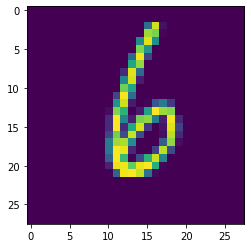

In [11]:
plt.imshow(X[2][0])

In [12]:
print(torch.argmax(net(X[2].view(-1,784))[0]))

tensor(6)


In [13]:
net.fc1, net.fc2, net.fc3, net.fc4

(Linear(in_features=784, out_features=64, bias=False),
 Linear(in_features=64, out_features=64, bias=False),
 Linear(in_features=64, out_features=64, bias=False),
 Linear(in_features=64, out_features=10, bias=False))

In [14]:
fc1_weights = list(net.fc1.parameters())

In [15]:
layers_to_update = [net.fc1, net.fc2, net.fc3]

In [16]:
layer_weights = [layer.weight.detach().numpy() for layer in layers_to_update]

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def undo_blockshaped(blocks, h, w):
    _, nrows, ncols = blocks.shape
    return blocks.reshape(h // nrows, -1, nrows, ncols).swapaxes(1, 2).reshape(h, w)

In [18]:
layer_weights[0].shape

(64, 784)

In [19]:
#B is determined by model architecture 
B = 4 
weight_blocks = [blockshaped(weights, B, B) for weights in layer_weights]

In [20]:
all_blocks = np.concatenate(weight_blocks)
all_blocks.shape
all_flat = [block.flatten() for block in all_blocks]

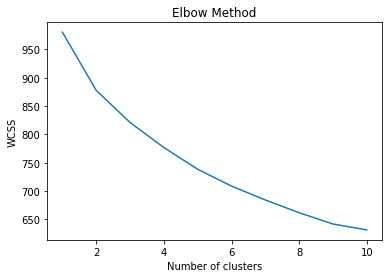

In [21]:
#N determined by architecture (how many legos can be fit)


N = 10
wcss = []
for i in range(1, N + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=N, random_state=0)
    kmeans.fit(all_flat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, N + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
def distance(block, center):
    return np.linalg.norm(block - center)

In [23]:
#DELTA is determined by accuracy constraints 
#and architecture (how much is needed for back propagation)
DELTA = abs(.06343089 - 1.923427408)/3
centers = [np.reshape(center, (B, B)) for center in kmeans.cluster_centers_]

lego_set = np.array([
    # First nearby center is good enough, not necessary to find actual closest
    next((center for center in centers if distance(block, center) < DELTA), block)
    for block in all_blocks
], dtype='float32')

k = (all_blocks != lego_set).reshape(-1, B * B).all(axis=1).sum()

print(k / len(lego_set))

0.9109100877192983


In [24]:
# for reconstruction, save metadata about blocks location when creating it
# and use that in above code to modify the layers directly

In [25]:
legos_used = 0

for i, layer in enumerate(layers_to_update):
    n_legos = len(weight_blocks[i])
    layer_legos = lego_set[legos_used:legos_used + n_legos]
    legos_used += n_legos
    updated_weight = undo_blockshaped(layer_legos, *layer.weight.shape)
    layer.weight.data = torch.as_tensor(updated_weight).float()

In [29]:
new_blocks = np.concatenate([blockshaped(layer.weight.detach().numpy(), B, B) for layer in layers_to_update])
print((new_blocks == lego_set).all())

for old_block, new_block in zip(all_blocks, new_blocks):
    assert distance(old_block, new_block) < DELTA

True


In [30]:
test()

0.27886666666666665

In [28]:
#see if this is solving the memory overhead is an issue 